In [1]:
# hack to make notebook appear full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas

import matplotlib.pyplot as plt

import mapalgo as MAP

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from importlib import reload

reload(MAP)

<module 'mapalgo' from '/Users/dbeach/Desktop/stableyes/src/mapalgo.py'>

In [4]:
autos = pandas.read_csv("../data/automobiles.csv", na_values="?")

categorical_cols = ["engine_type", "fuel_type", "fuel_system", "aspiration", "num_of_doors", "body_style", "drive_wheels", "engine_location", "num_of_cylinders"]

orig = autos
autos = pandas.get_dummies(autos, columns=categorical_cols)
autos = autos.join(orig[categorical_cols])

print(autos.columns)

Index(['symbolizing', 'normalized_losses', 'make', 'wheel_base', 'length',
       'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price', 'engine_type_dohc', 'engine_type_dohcv',
       'engine_type_l', 'engine_type_ohc', 'engine_type_ohcf',
       'engine_type_ohcv', 'engine_type_rotor', 'fuel_type_diesel',
       'fuel_type_gas', 'fuel_system_1bbl', 'fuel_system_2bbl',
       'fuel_system_4bbl', 'fuel_system_idi', 'fuel_system_mfi',
       'fuel_system_mpfi', 'fuel_system_spdi', 'fuel_system_spfi',
       'aspiration_std', 'aspiration_turbo', 'num_of_doors_four',
       'num_of_doors_two', 'body_style_convertible', 'body_style_hardtop',
       'body_style_hatchback', 'body_style_sedan', 'body_style_wagon',
       'drive_wheels_4wd', 'drive_wheels_fwd', 'drive_wheels_rwd',
       'engine_location_front', 'engine_location_rear',
       'num_of_cylinders_eight', 'num_of_cylinders_

In [5]:
def select_cols(prefix):
    selected = [col for col in autos.columns if col.startswith(prefix)]
    assert selected, "no columns selected"
    return selected

meta_attrs = [
    "make", "engine_type", "fuel_type", "aspiration", "num_of_doors", "body_style",
    "drive_wheels", "engine_location", "num_of_cylinders", "fuel_system"
]
engine_attrs = ["engine_size", "bore", "stroke", "compression_ratio", "horsepower", "peak_rpm"]
engine_cats = ["engine_type", "fuel_type", "fuel_system", "num_of_cylinders", "aspiration"]
for cat in engine_cats:
    engine_attrs += select_cols(cat + "_")

body_attrs = ["wheel_base", "length", "width", "height", "curb_weight"]
body_cats = ["num_of_doors", "body_style", "drive_wheels", "engine_location"]
for cat in body_cats:
    body_attrs += select_cols(cat + "_")


In [6]:
avail_data = autos[meta_attrs + engine_attrs + body_attrs].dropna()

engine_data = avail_data[engine_attrs].as_matrix()
engine_data[:,0:6] = MAP.zscore(engine_data[:,0:6])
engine_data[:,6:] *= 2

body_data = avail_data[body_attrs].as_matrix()
body_data[:,0:5] = MAP.zscore(body_data[:,0:5])
body_data[:,5:] *= 2

In [7]:
engine_map0 = MAP.create_map_from_data("Engine (unconstrained)", engine_data, perplexity=20.0)
body_map0 = MAP.create_map_from_data("Body (unconstrained)", body_data, perplexity=20.0)

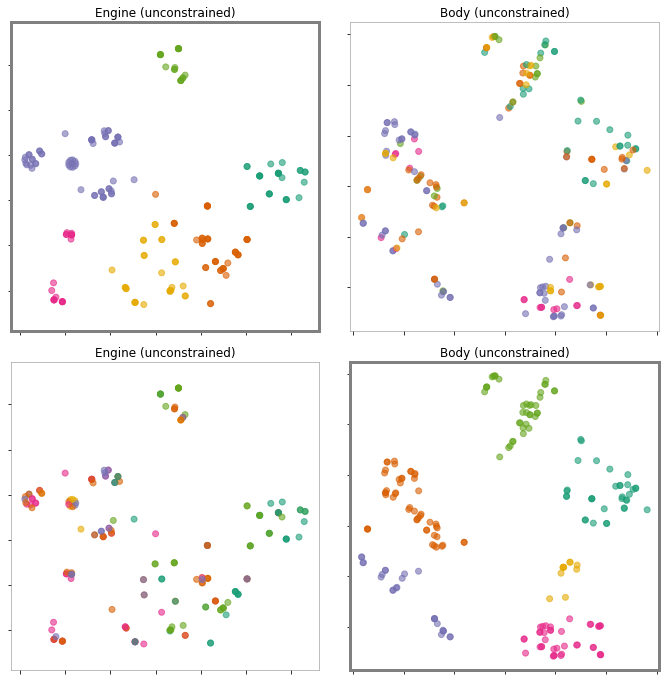

In [12]:
MAP.show_map_matrix([engine_map0, body_map0], size=5, score=False)

In [9]:
concat_data = np.hstack([engine_data, body_data])
concat_map = MAP.create_map_from_data("Concat", concat_data, perplexity=20.0)

In [10]:
engine_map = MAP.create_map_from_data("Engine", engine_data, perplexity=20.0, prior=concat_map)
body_map = MAP.create_map_from_data("Body", body_data, perplexity=20.0, prior=concat_map)

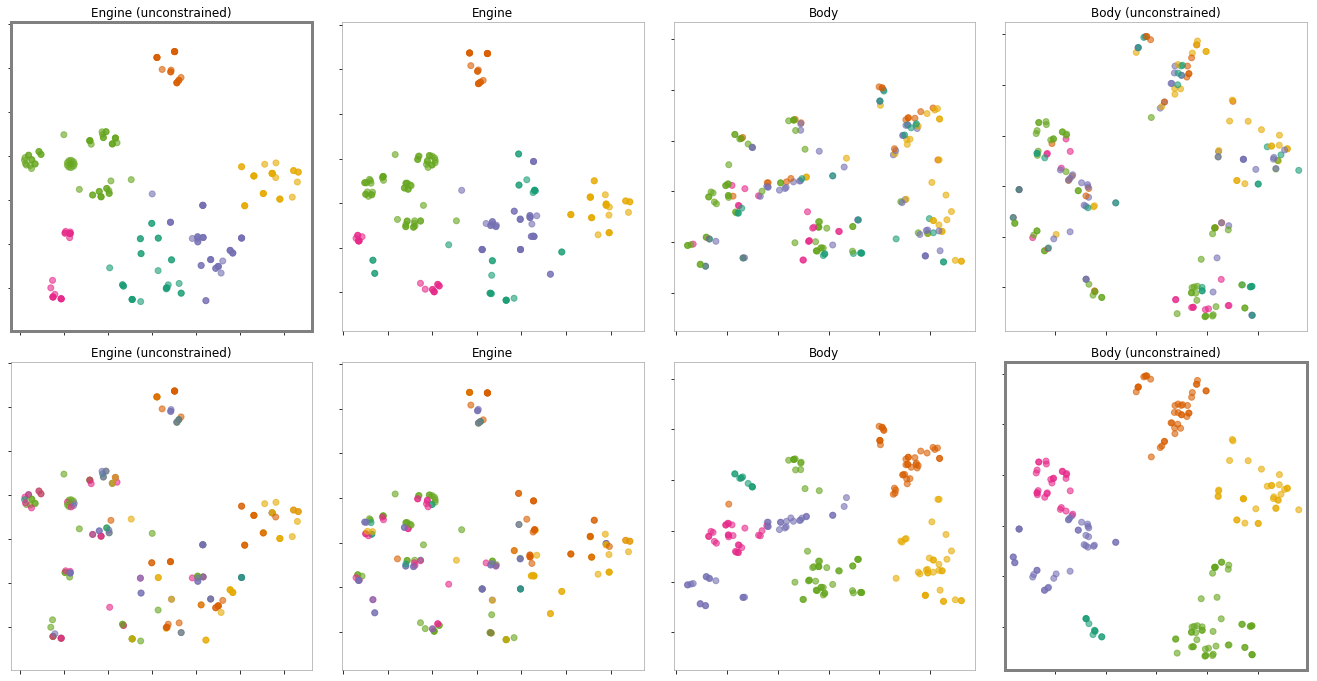

In [11]:
MAP.show_map_matrix([engine_map0, engine_map, body_map, body_map0], keys=[engine_map0, body_map0], size=5, score=False)

In [13]:
def make_weighted_map(p_engine, prior=concat_map):
    data = np.hstack([engine_data * p_engine, body_data * (1 - p_engine)])
    name = f"Weighted {p_engine:.0%} Engine"
    return MAP.create_map_from_data(name, data, prior=prior)

def make_linear_map(p_engine, prior=concat_map):
    prob = engine_map.prob * p_engine + body_map.prob * (1 - p_engine)
    name = f"Linear {p_engine:.0%} Engine"
    return MAP.create_map(name, prob, prior=prior)

In [14]:
wmap75 = make_weighted_map(0.75)
wmap50 = make_weighted_map(0.50)
wmap25 = make_weighted_map(0.25)

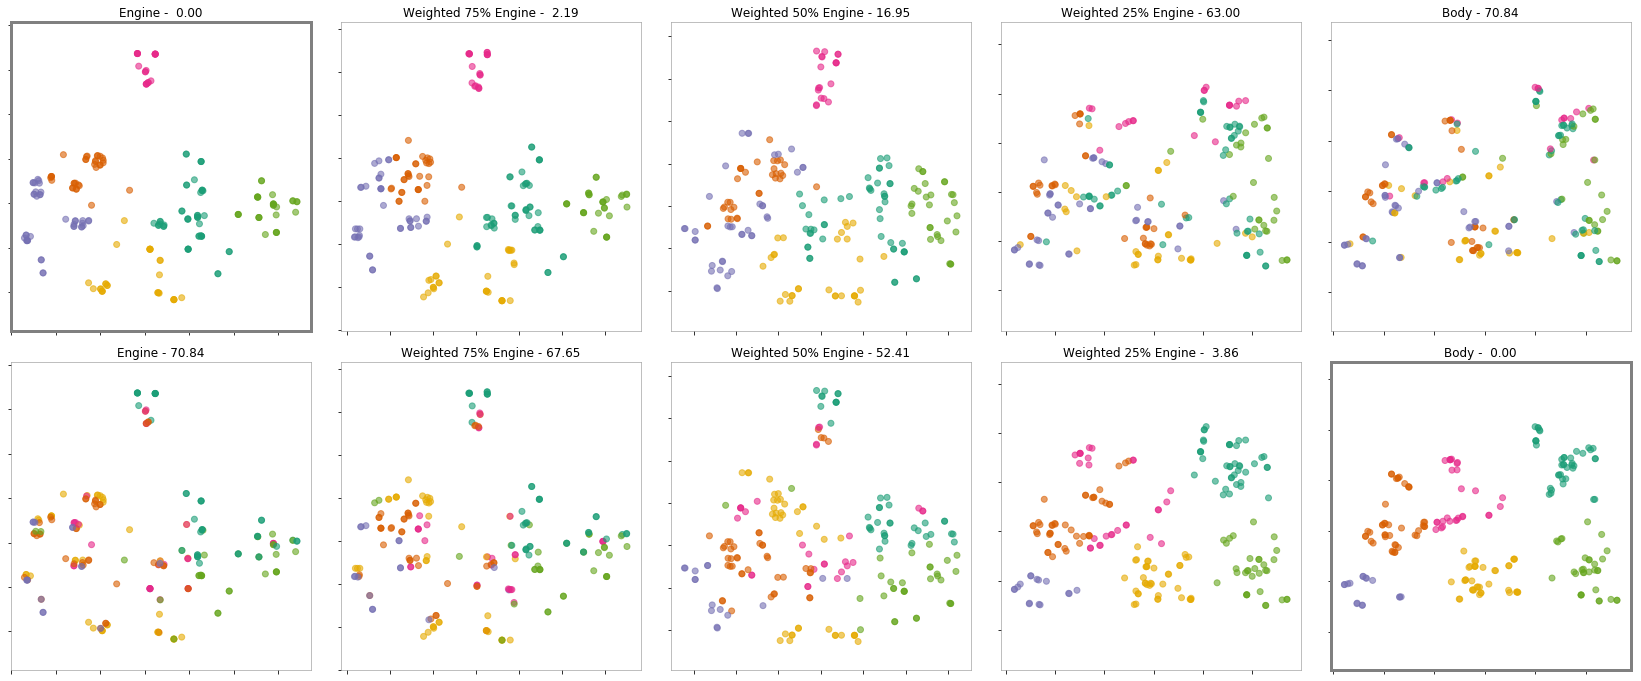

In [15]:
MAP.show_map_matrix([engine_map, wmap75, wmap50, wmap25, body_map], keys=[engine_map, body_map])

In [16]:
lmap75 = make_linear_map(0.75)
lmap50 = make_linear_map(0.50)
lmap25 = make_linear_map(0.25)

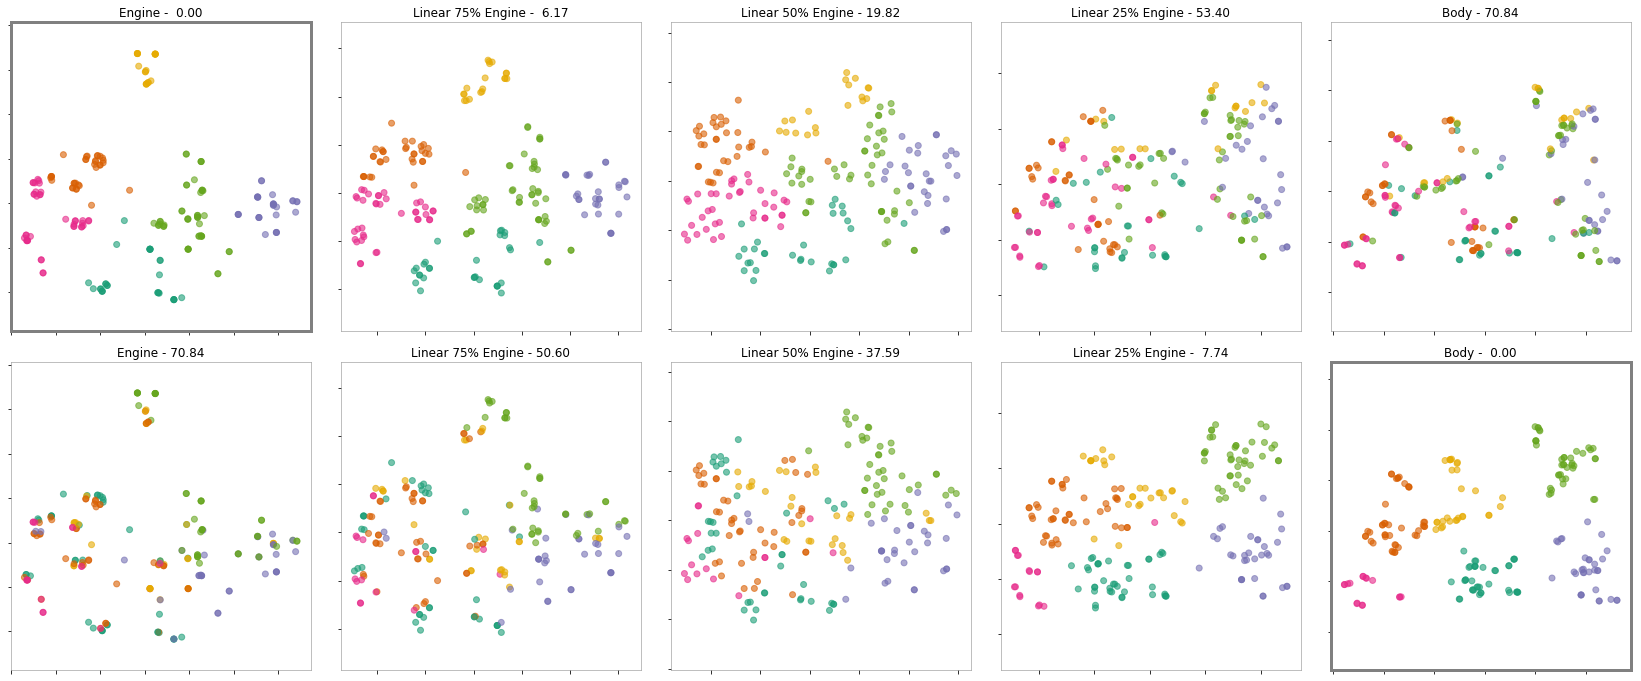

In [17]:
MAP.show_map_matrix([engine_map, lmap75, lmap50, lmap25, body_map], keys=[engine_map, body_map])

In [26]:
COLORS = [
    "#1b9e77",
    "#d95f02",
    "#7570b3",
    "#e7298a",
    "#66a61e",
    "#e6ab02",
    "#a6761d",
    "#666666",
]

def color_by(ax, map, meta_attr, legend=True, s=40):
    vals = avail_data[meta_attr].unique()
    mapping = dict(zip(vals, range(len(vals))))
    colors = [COLORS[mapping[c] % len(COLORS)] for c in avail_data[meta_attr]]
    ax.scatter(map.y[:,0], map.y[:,1], color=colors, s=s)
    if legend:
        for style, idx in mapping.items():
            ax.scatter([], [], color=COLORS[idx % len(COLORS)], label=style, s=s)
        ax.legend()
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(plt.NullFormatter())
    ax.axis('equal')
    ax.set_title(f"{map.name} - {meta_attr}")

def blend_compare(meta_attr):
    fig, ax = plt.subplots(2, 5, figsize=(30,14))
    fig.suptitle(meta_attr, size=30)
        
    color_by(ax[0,0], engine_map, meta_attr, legend=False)
    color_by(ax[0,1], wmap75, meta_attr, legend=False)
    color_by(ax[0,2], wmap50, meta_attr, legend=True)
    color_by(ax[0,3], wmap25, meta_attr, legend=False)
    color_by(ax[0,4], body_map, meta_attr, legend=False)

    color_by(ax[1,0], engine_map, meta_attr, legend=False)
    color_by(ax[1,1], lmap75, meta_attr, legend=False)
    color_by(ax[1,2], lmap50, meta_attr, legend=False)
    color_by(ax[1,3], lmap25, meta_attr, legend=False)
    color_by(ax[1,4], body_map, meta_attr, legend=False)
    
    fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, wspace=0.05, hspace=0.05, top=0.9)

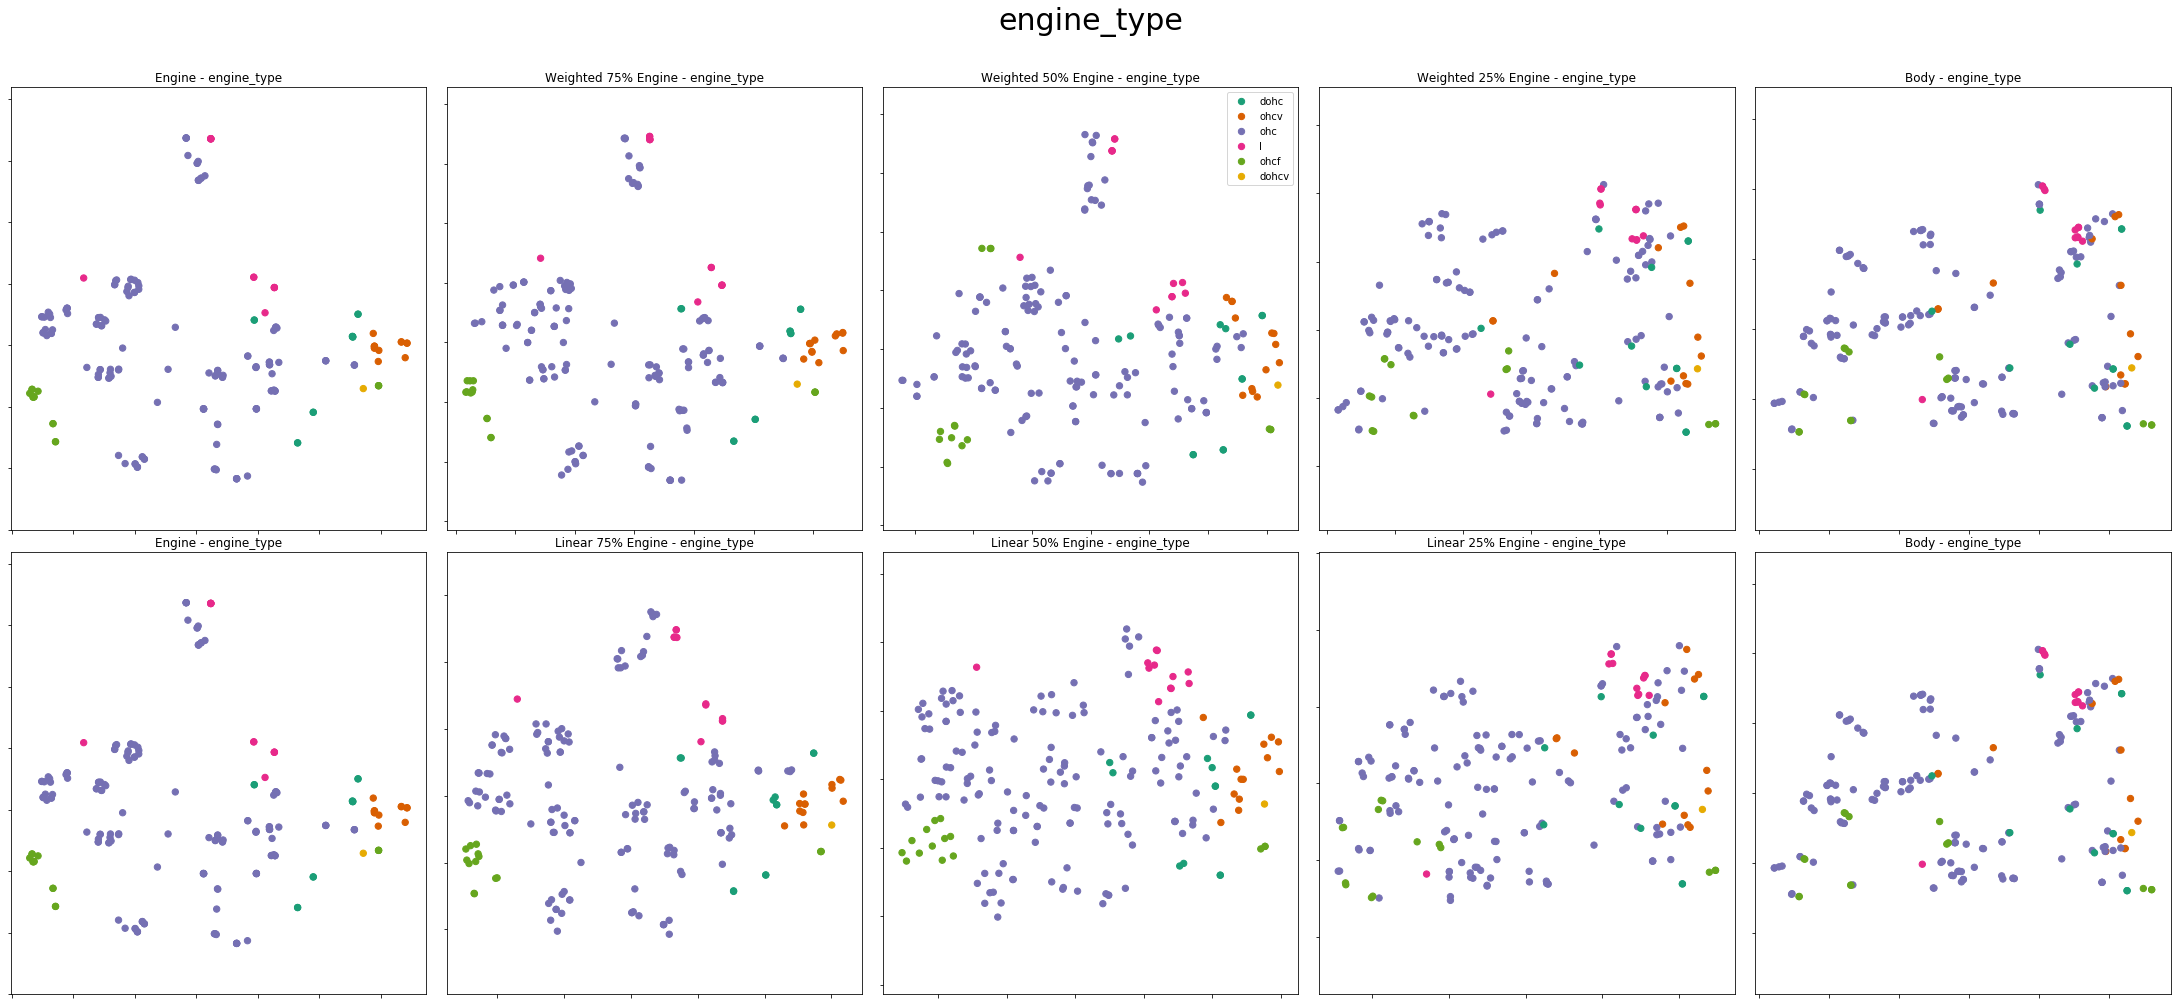

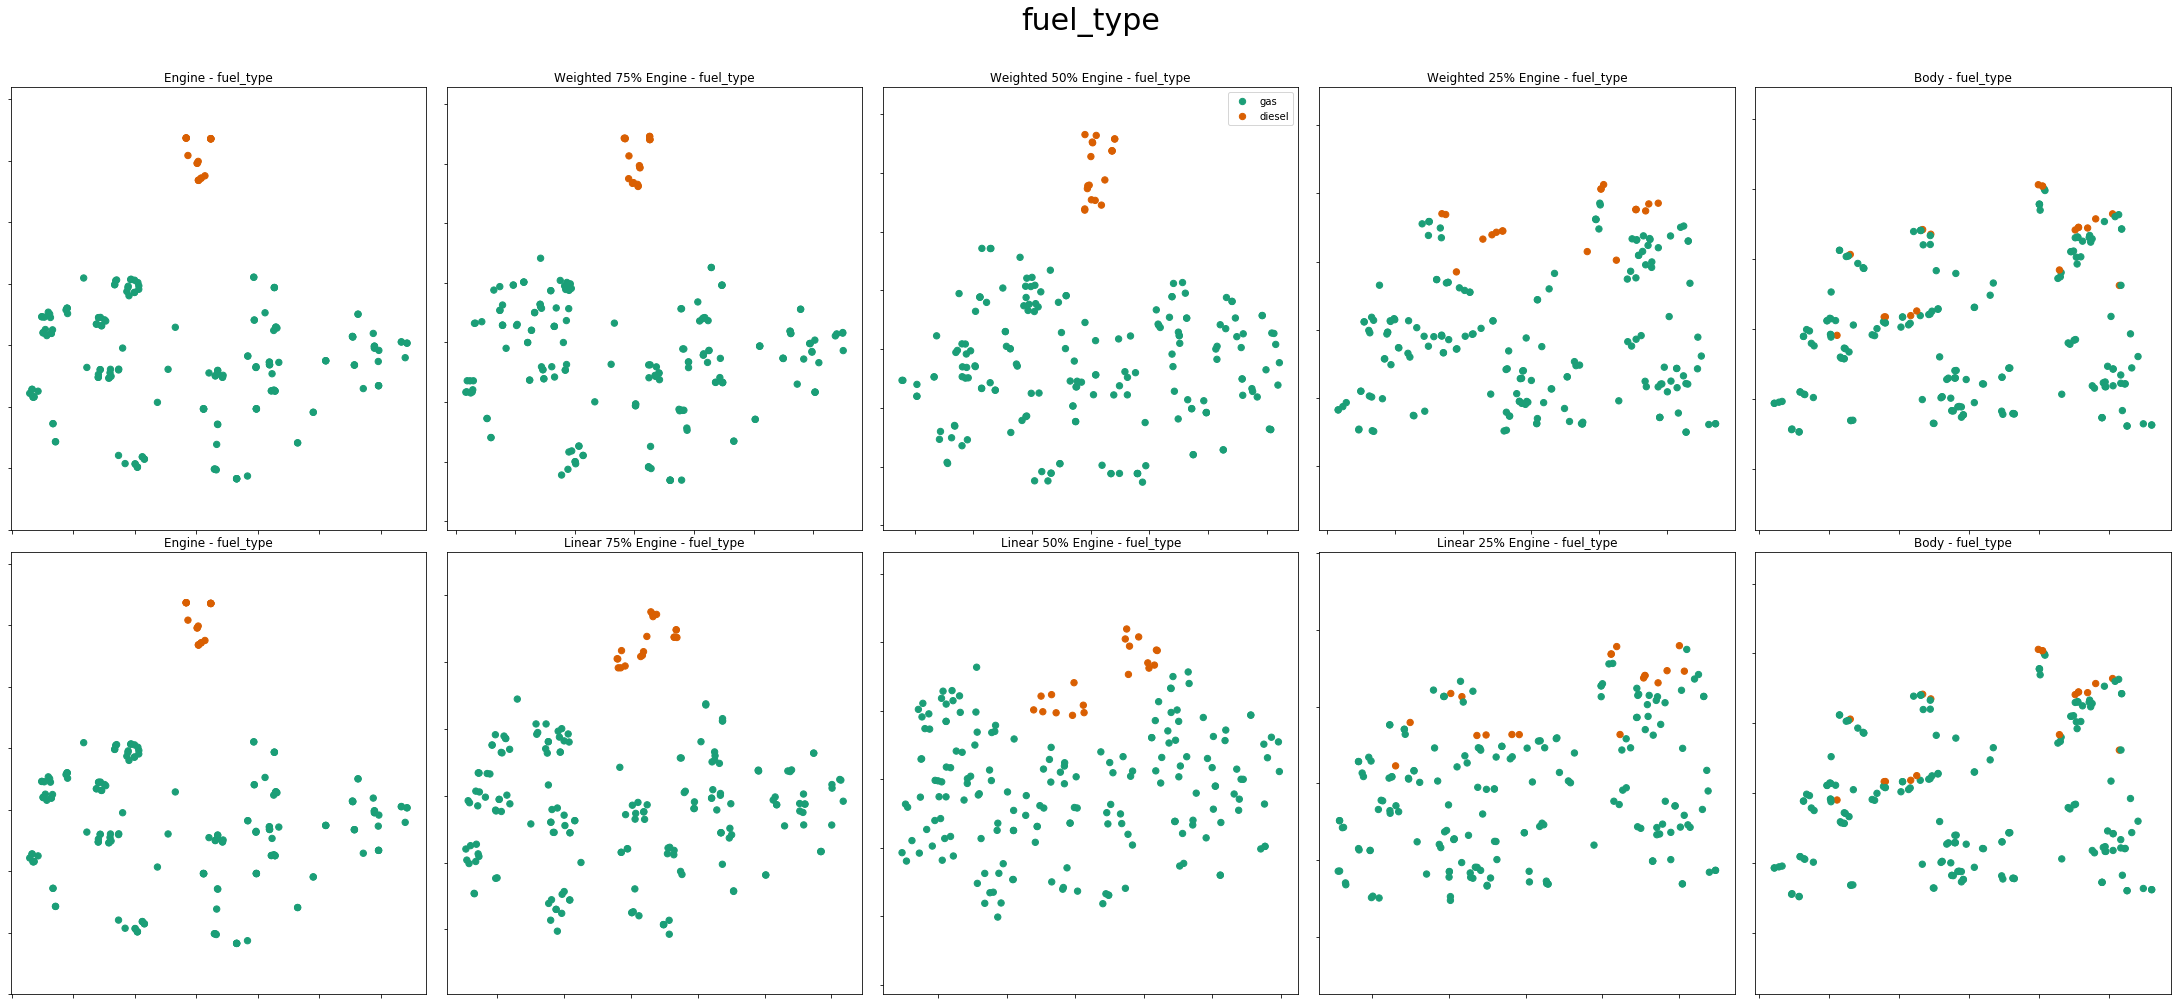

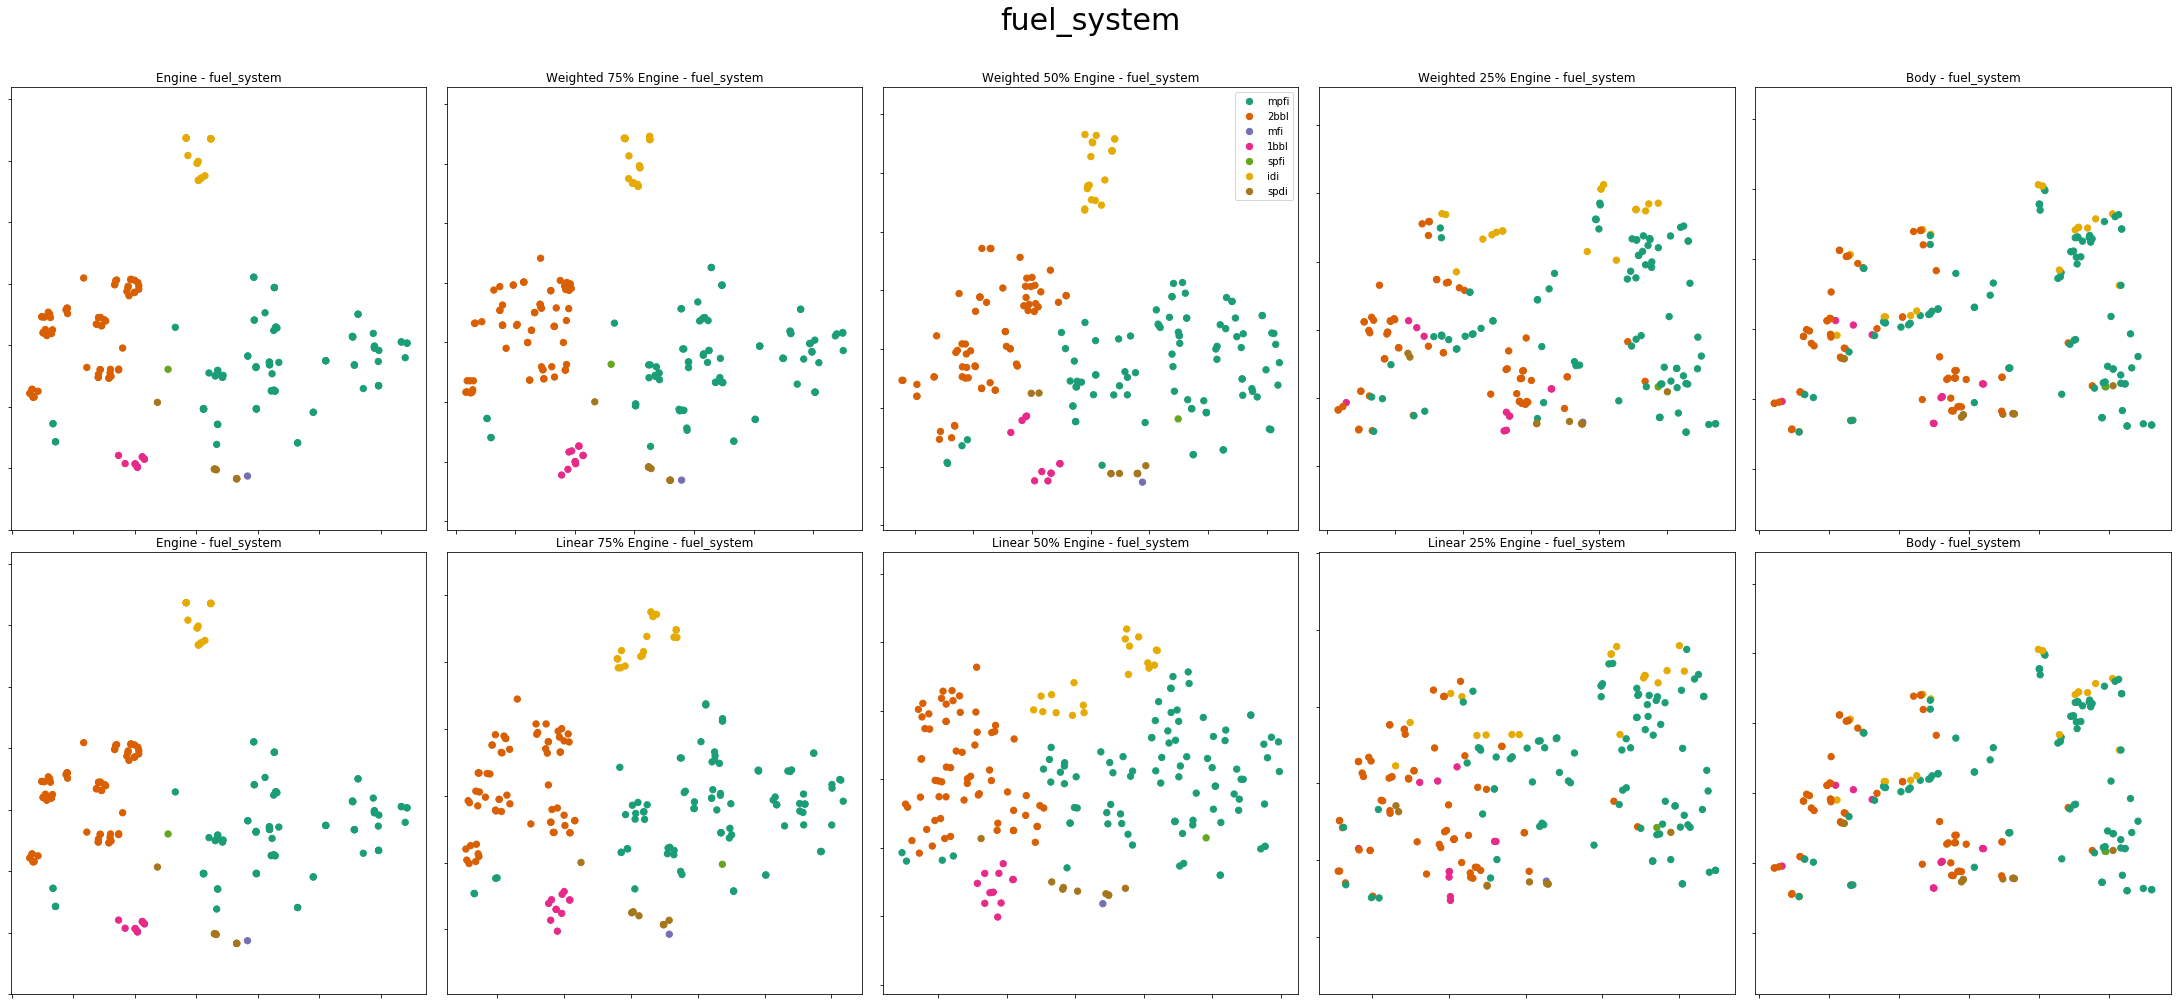

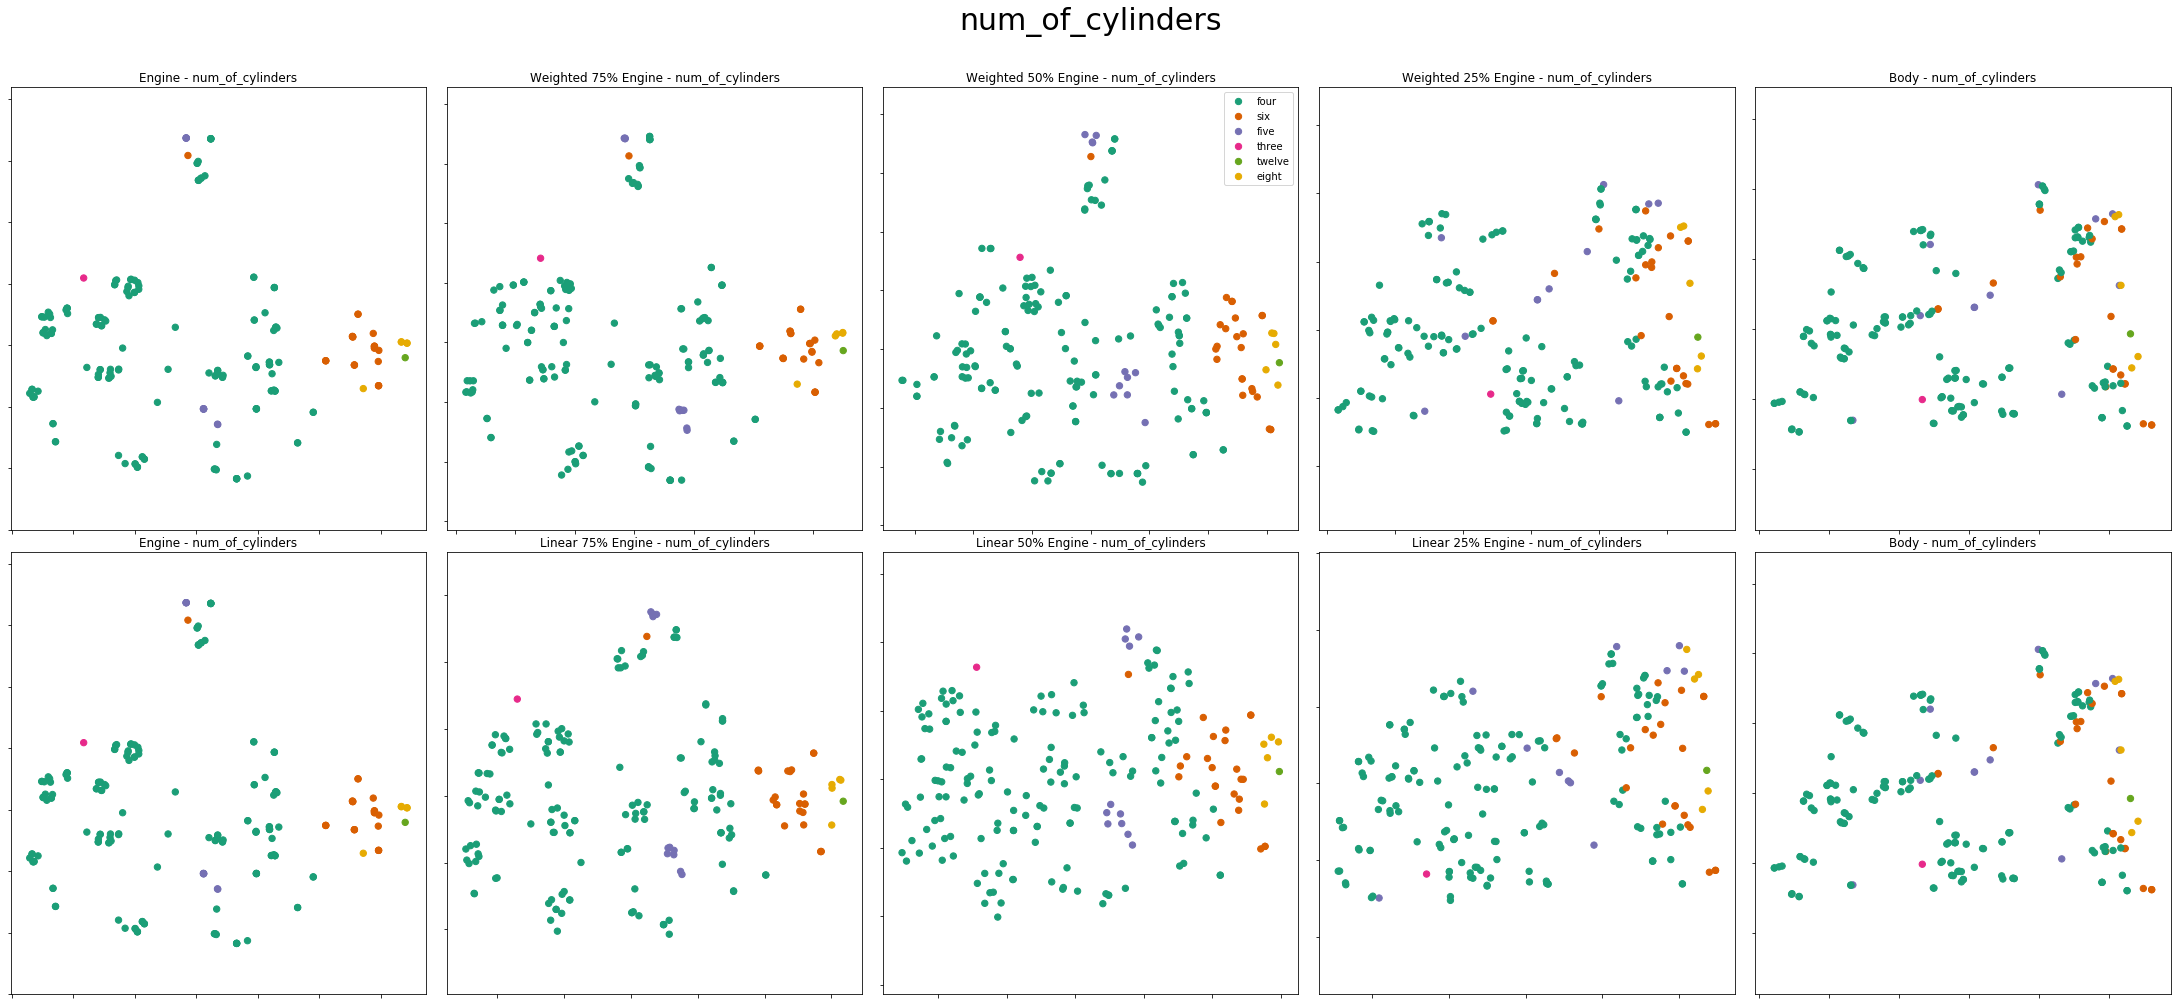

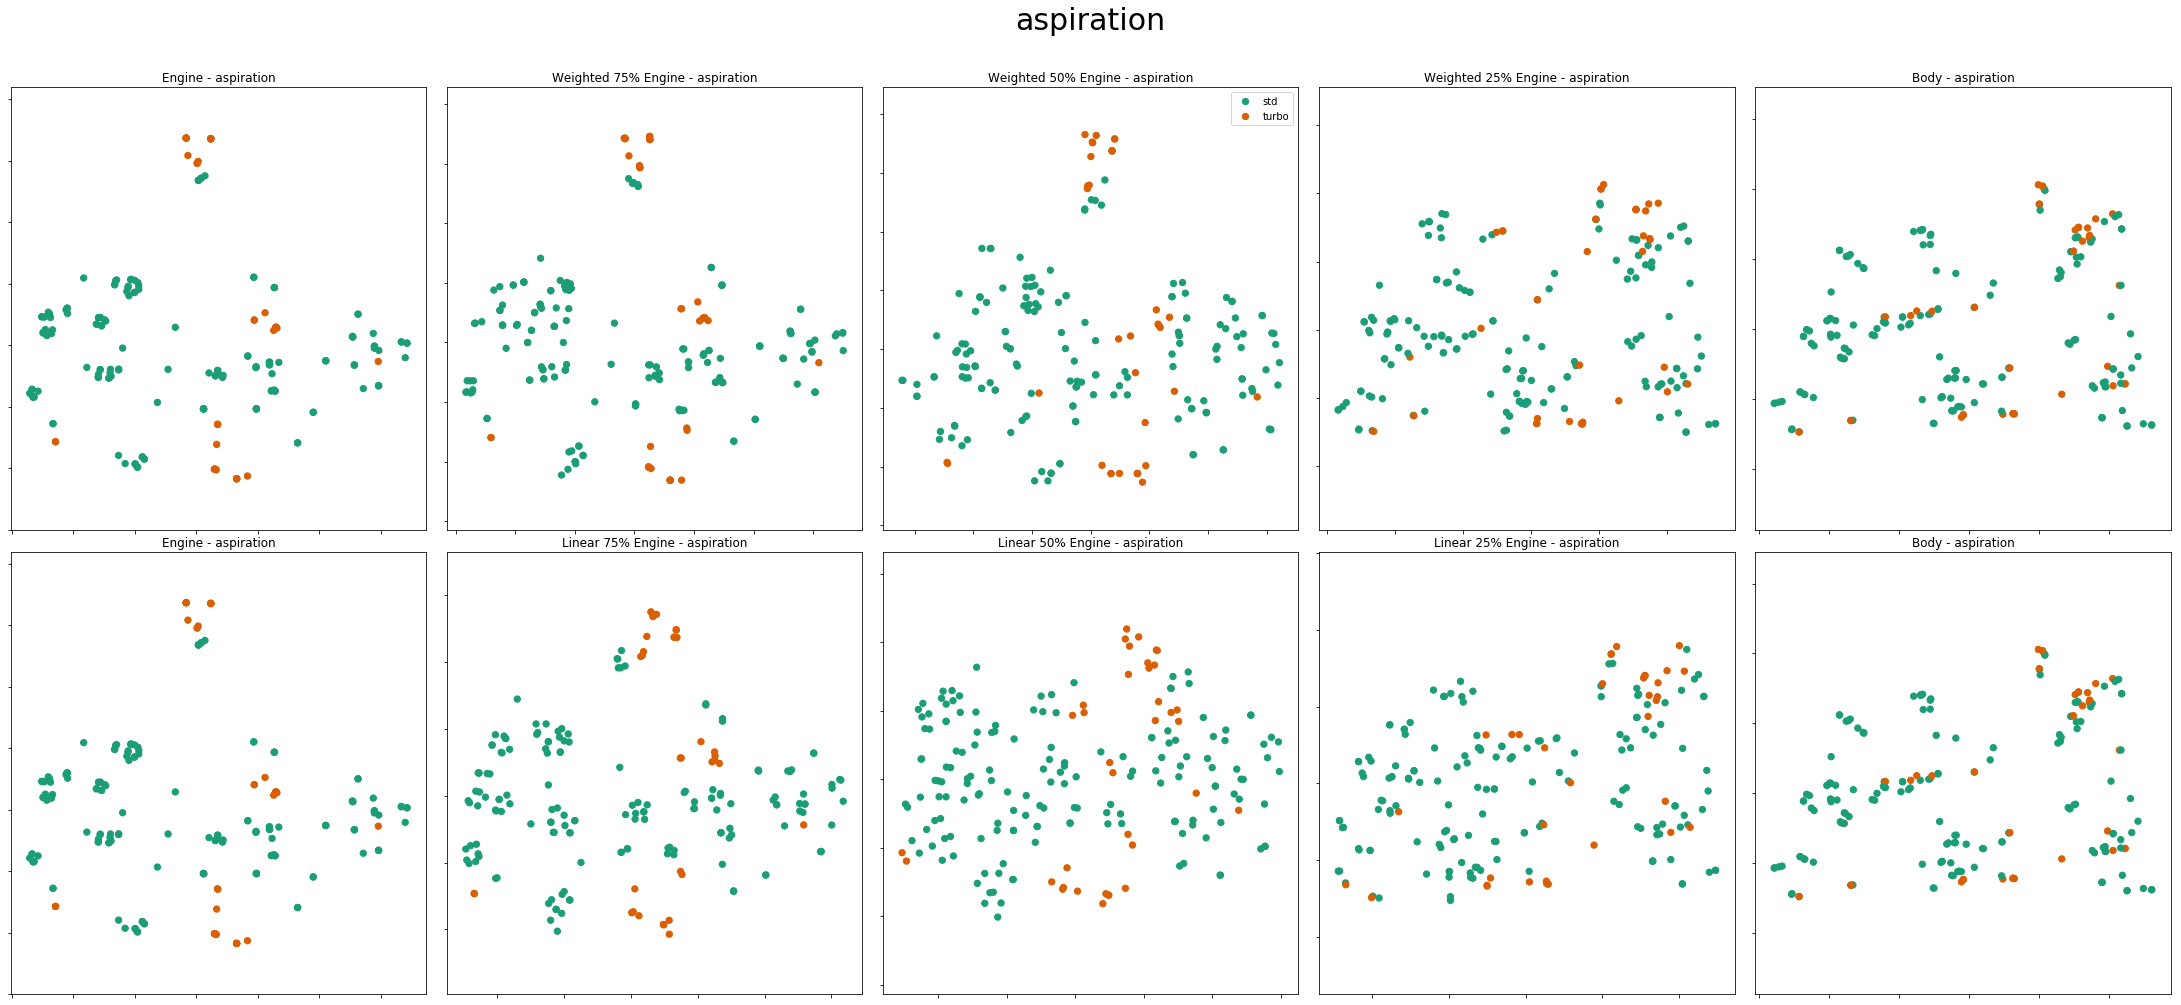

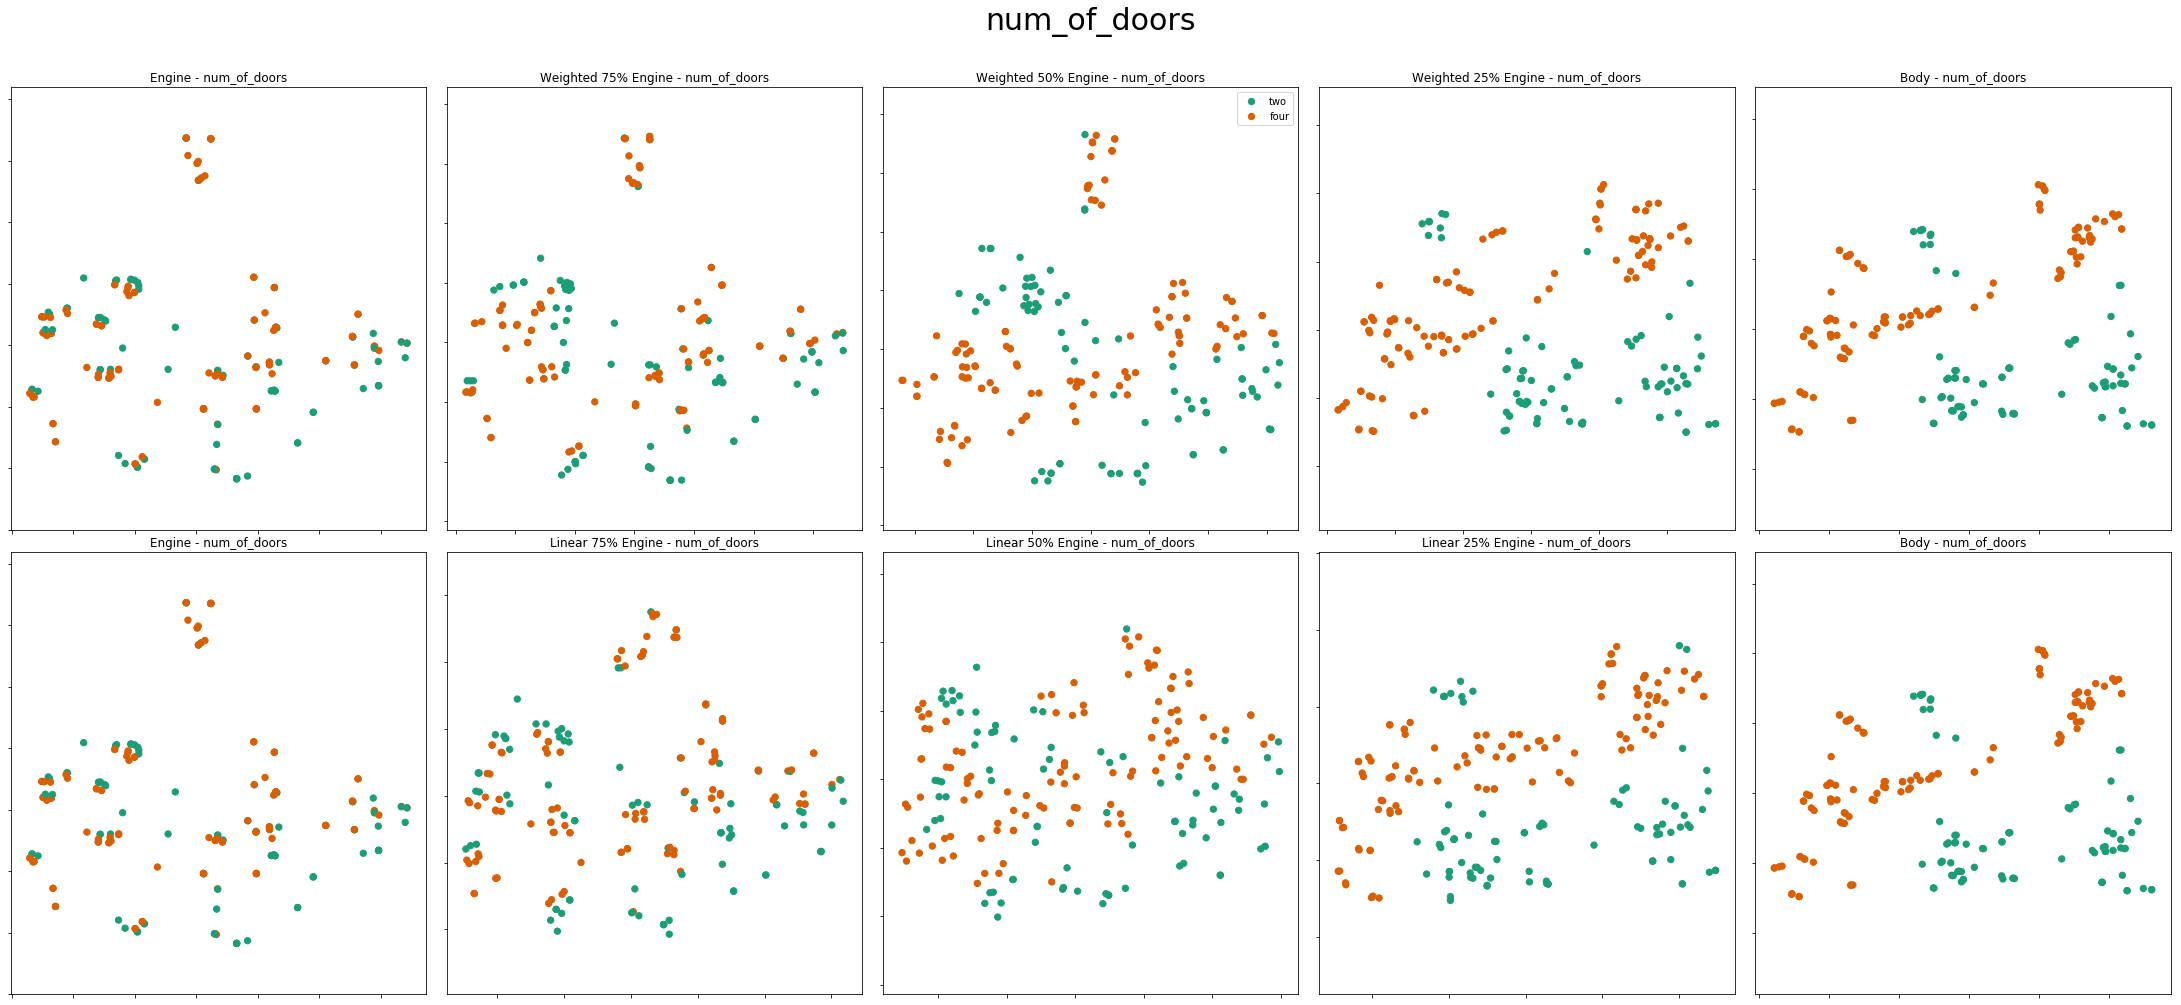

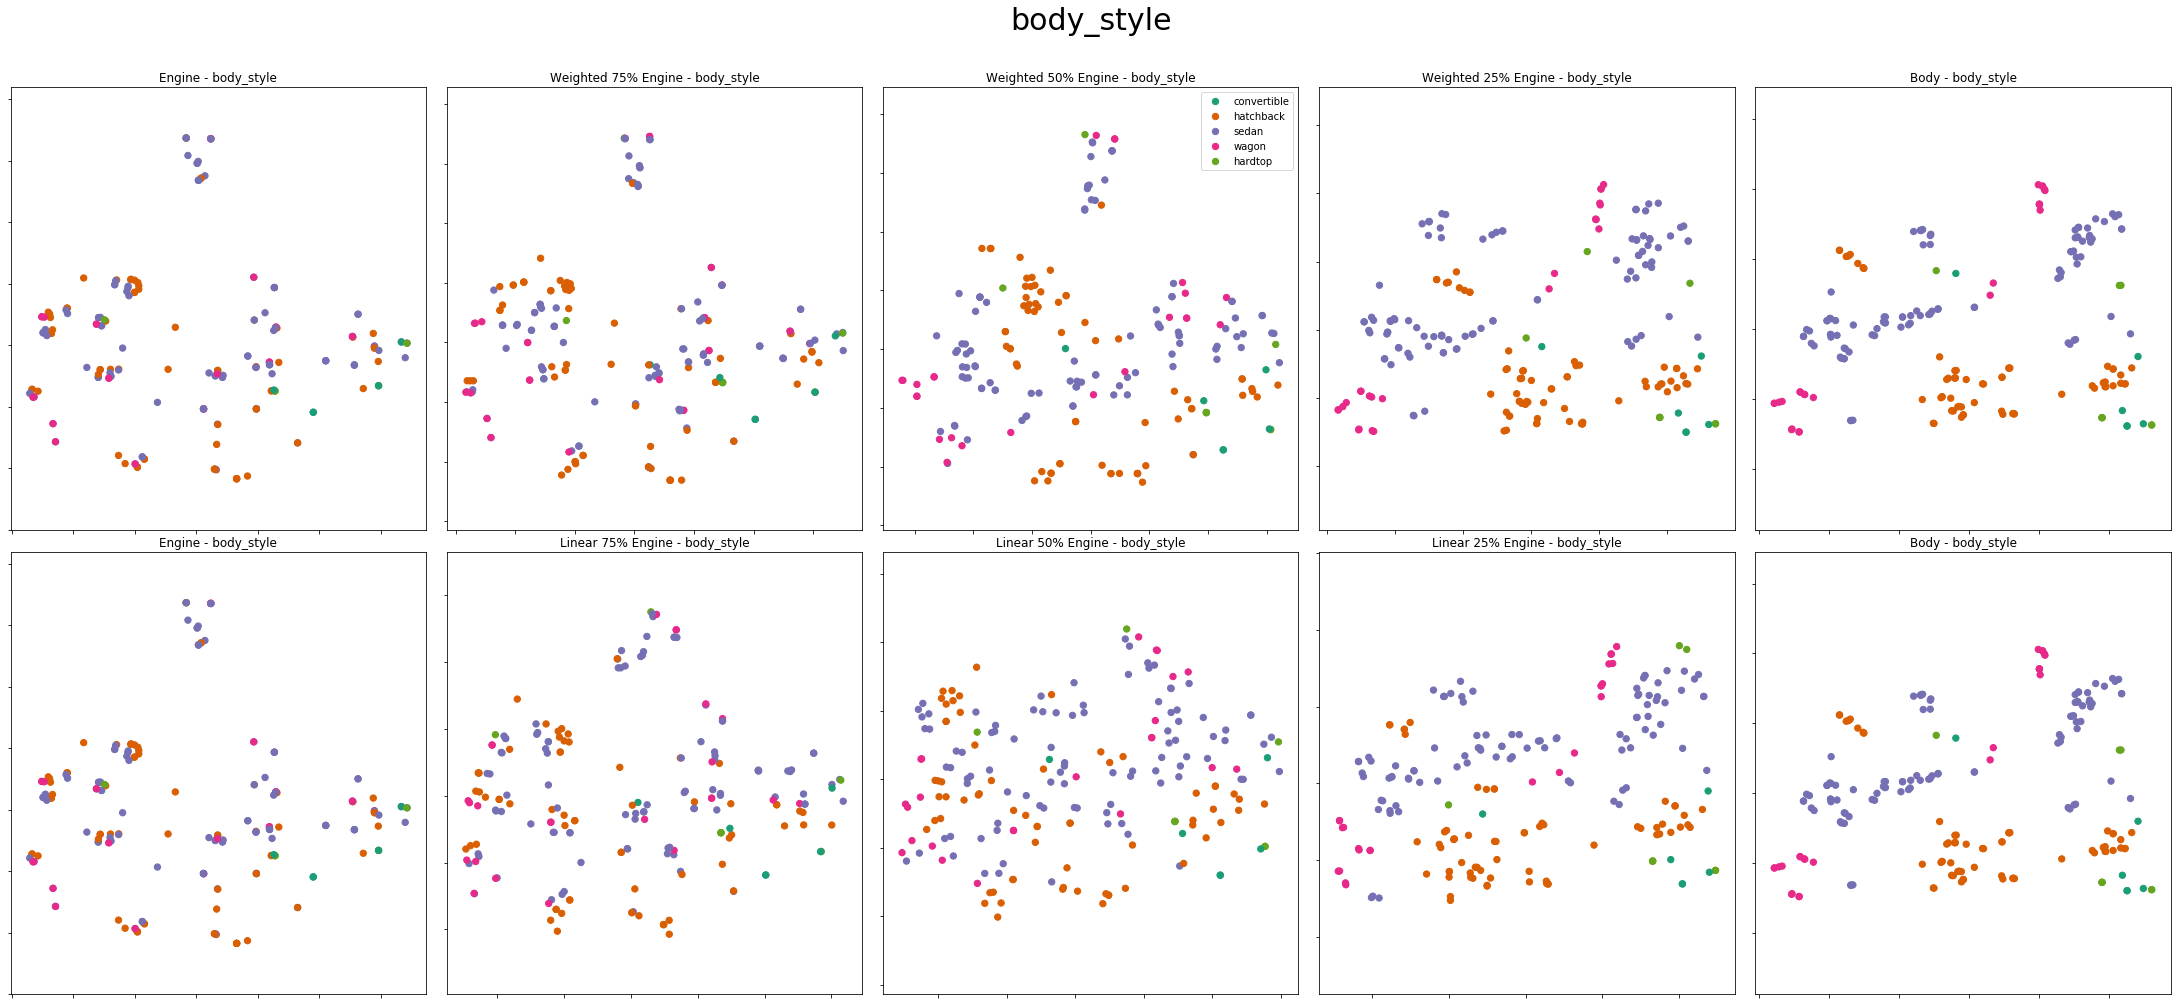

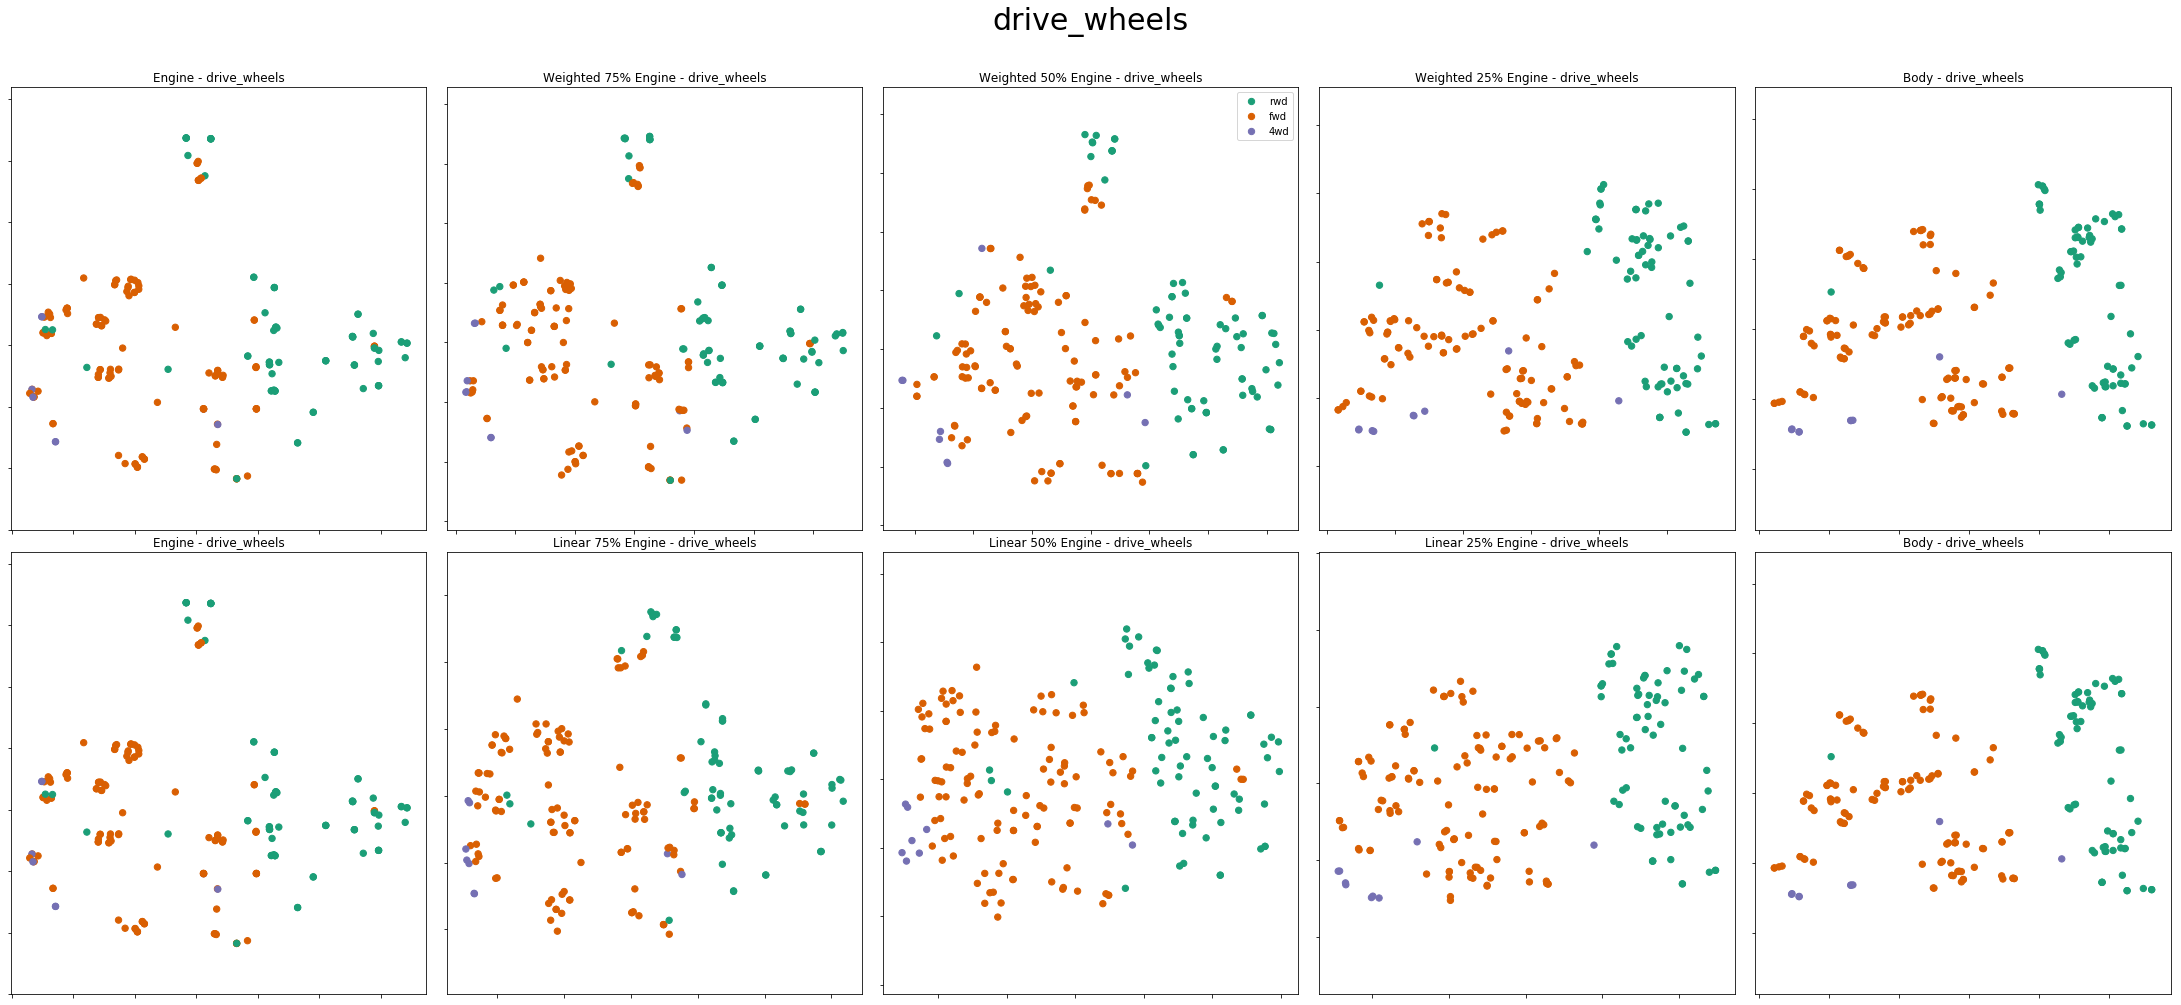

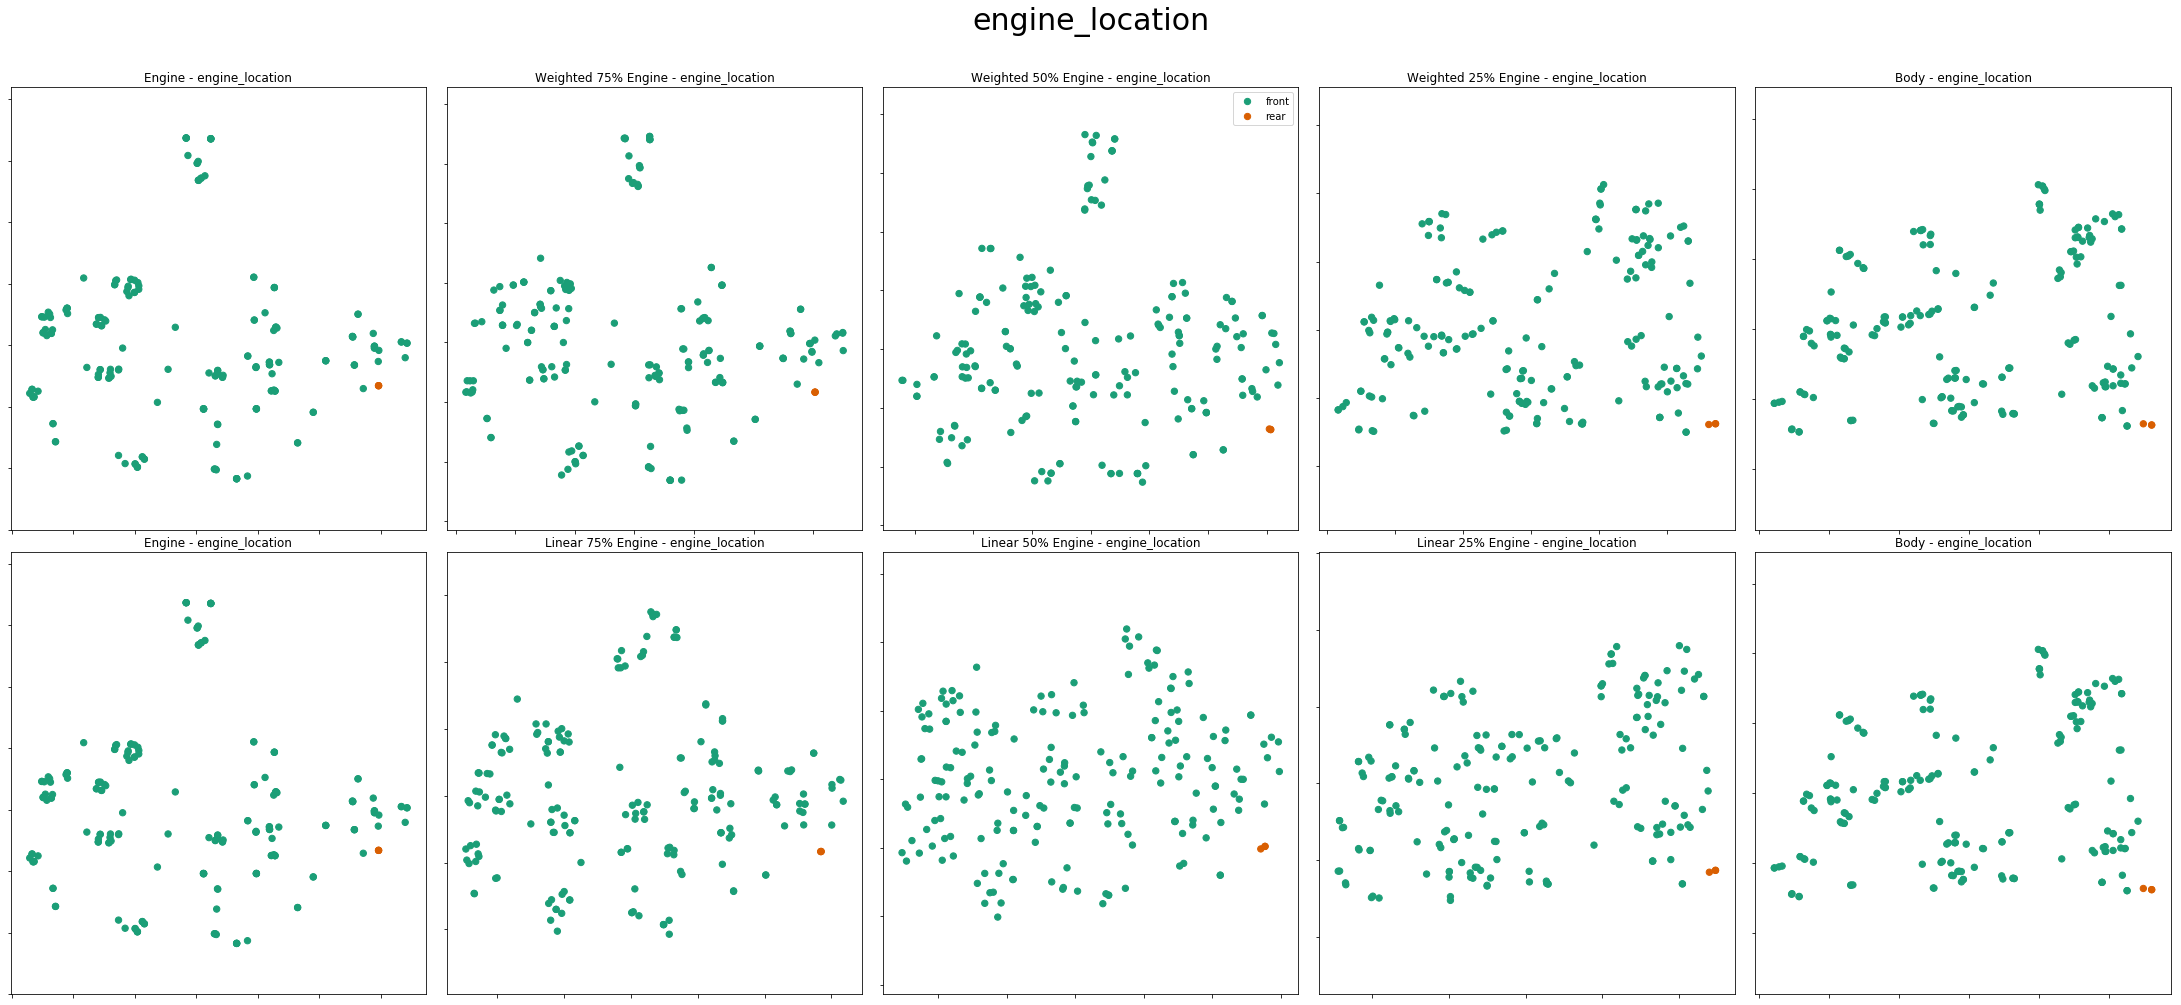

In [27]:
all_cats = engine_cats + body_cats
for cat in all_cats:
    blend_compare(cat)

In [21]:
from scipy.interpolate import spline
from matplotlib.collections import LineCollection

def plot_motion(maps, meta_attr, legend=True, ax=None):
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(20,20))
    Y = np.array([m.y for m in maps])
    D, N, _ = Y.shape
    vals = avail_data[meta_attr].unique()
    mapping = dict(zip(vals, range(len(vals))))
    colors = [COLORS[mapping[s] % len(COLORS)] for s in avail_data[meta_attr]]
    torig = np.arange(D)
    tnew = np.linspace(0, D-1, 100)
    lwidths = np.linspace(1, 8, 100)
    for i in range(N):
        xvals = spline(torig, Y[:,i,0], tnew)
        yvals = spline(torig, Y[:,i,1], tnew)
        points = np.array([xvals, yvals]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lines = LineCollection(segments, linewidths=lwidths, color=colors[i], alpha=0.2)
        ax.add_collection(lines)
    ax.scatter(Y[0,:,0], Y[0,:,1], s=100, color=colors, facecolors='none')
    ax.scatter(Y[-1,:,0], Y[-1,:,1], s=100, color=colors)
    
    if legend:
        for style, idx in mapping.items():
            ax.scatter([], [], color=COLORS[idx % len(COLORS)], label=style, s=100)
        ax.scatter([], [], color='grey', label=maps[0].name, s=100, facecolors='none')
        ax.scatter([], [], color='grey', label=maps[-1].name, s=100)
        ax.legend()
    
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_formatter(plt.NullFormatter())
    ax.axis('equal')
    ax.set_title("{} through {} colored by {}".format(maps[0].name, maps[-1].name, meta_attr))

In [22]:
linear_maps = []
prior = engine_map
for p in np.linspace(0.0, 1.0, 11):
    m = MAP.create_map("Linear {:.0%} Engine".format(1-p), engine_map.prob * (1-p) + body_map.prob * p, prior=prior)
    prior = m
    linear_maps.append(m)

In [23]:
concat_maps = []
prior = engine_map
for p in np.linspace(0.0, 1.0, 11):
    data = np.hstack([engine_data * (1-p), body_data * p])
    m = MAP.create_map_from_data("Weighted {:.0%} Engine".format(1-p), data, prior=prior)
    prior = m
    concat_maps.append(m)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


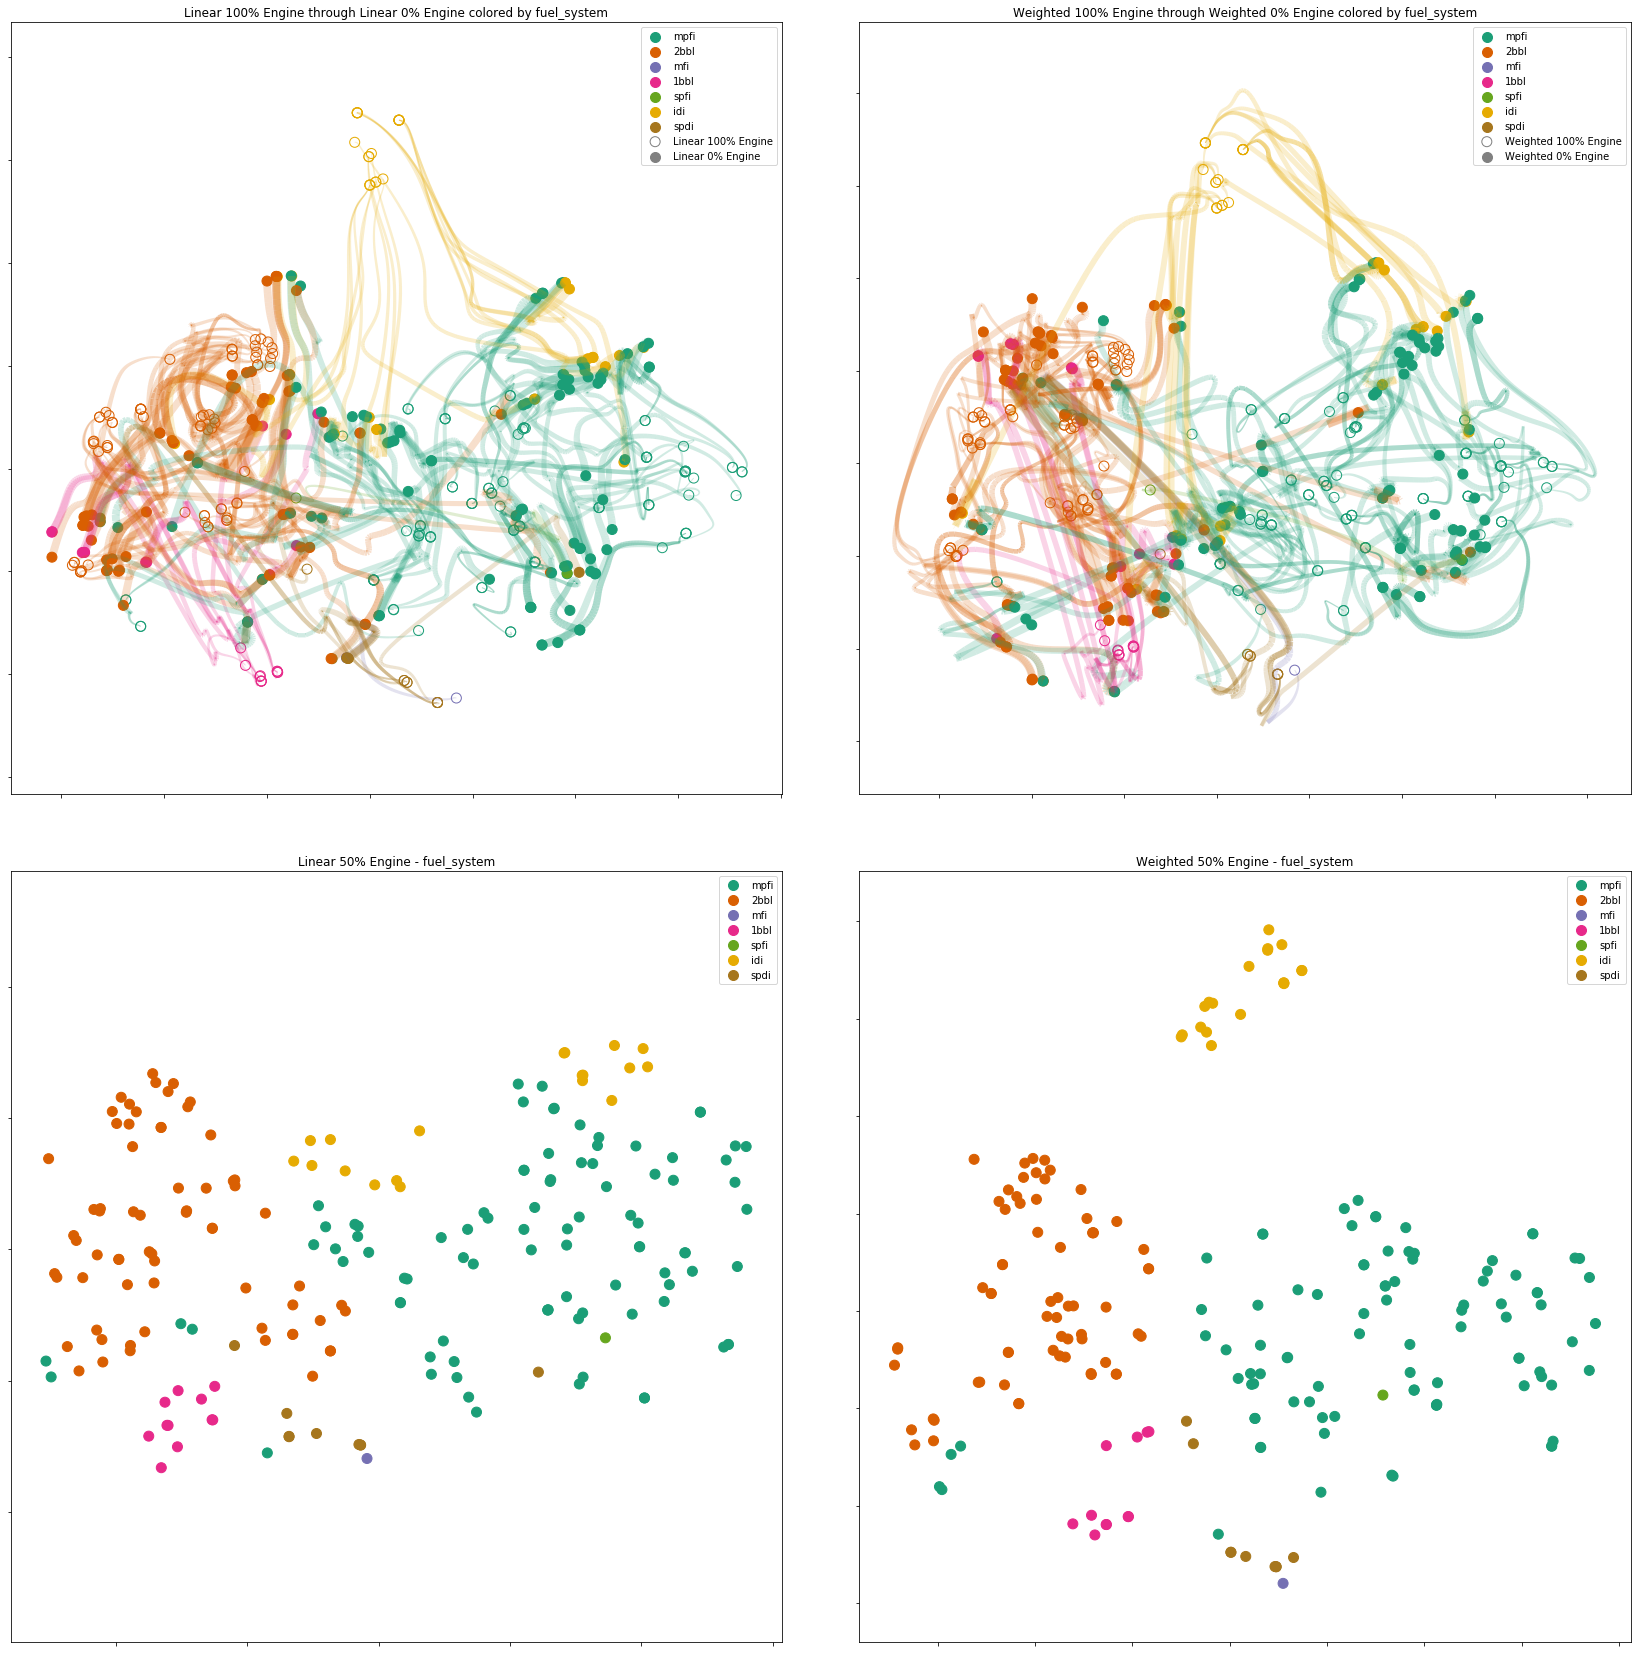

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))
plot_motion(linear_maps, "fuel_system", ax=ax[0,0])
plot_motion(concat_maps, "fuel_system", ax=ax[0,1])
color_by(ax[1,0], linear_maps[5], "fuel_system", s=100)
color_by(ax[1,1], concat_maps[5], "fuel_system", s=100)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1, wspace=0.1)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  app.launch_new_instance()
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.


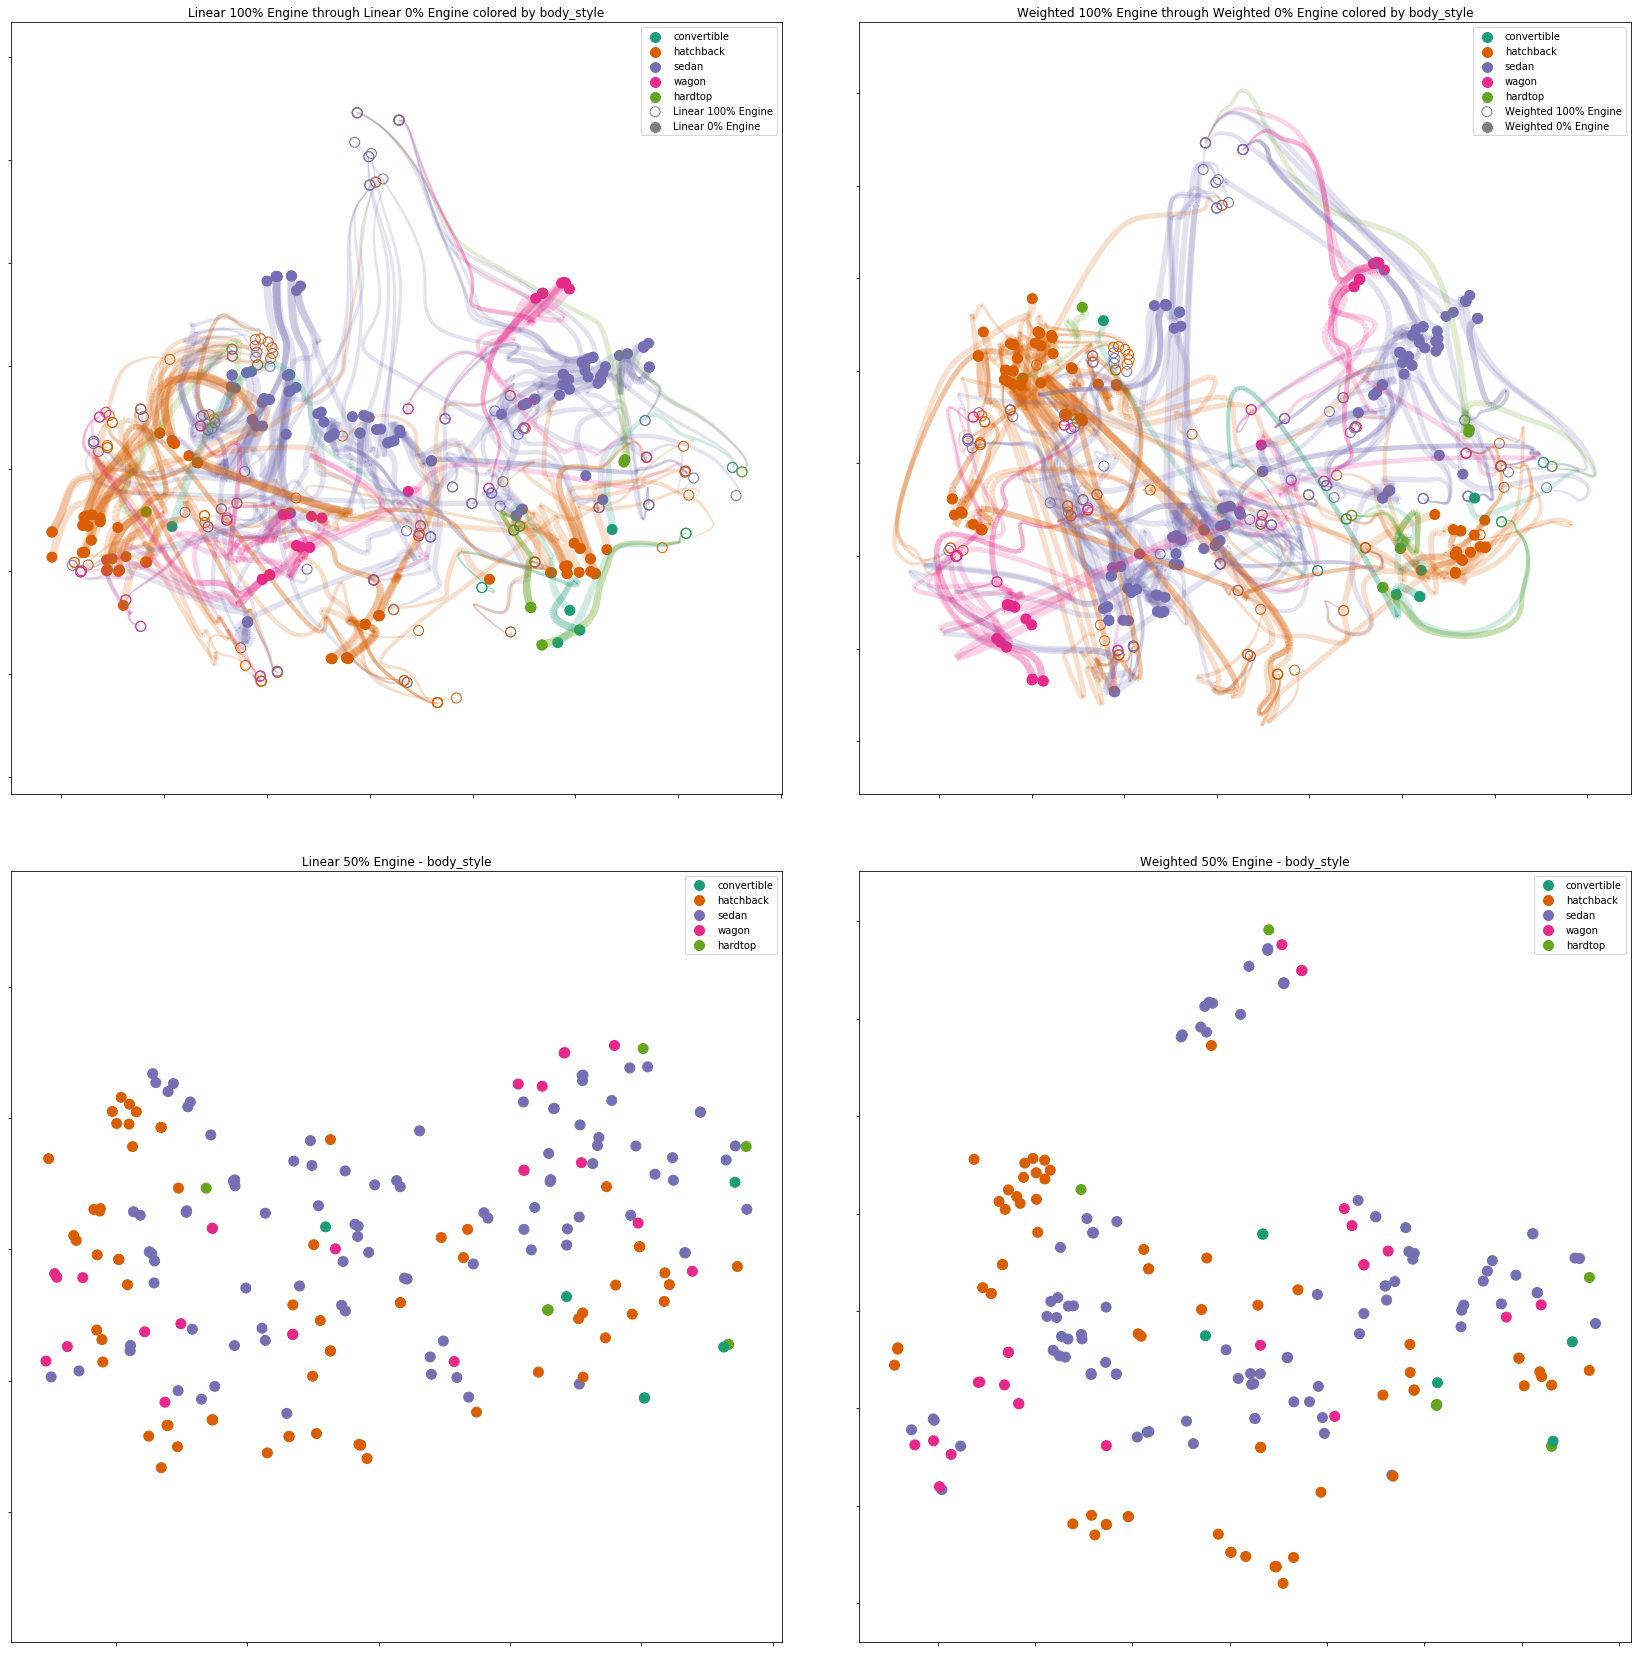

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(25, 25))
plot_motion(linear_maps, "body_style", ax=ax[0,0])
plot_motion(concat_maps, "body_style", ax=ax[0,1])
color_by(ax[1,0], linear_maps[5], "body_style", s=100)
color_by(ax[1,1], concat_maps[5], "body_style", s=100)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.1, wspace=0.1)